In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


#Import

In [ ]:
import os, os.path
from subprocess import getoutput

import tensorflow as tf
from tensorflow import keras as ks

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
import cv2
#Data visualization
import seaborn as sns
from matplotlib import pyplot as plt

import glob
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import time
import math

from collections import Counter
from collections import defaultdict
from collections import OrderedDict

from tensorflow.keras import layers
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import ConvLSTM2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Softmax

from collections import Counter
from collections import defaultdict
from collections import OrderedDict

import itertools
import collections
import statistics

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!git clone https://github.com/PaoloDarienzo/NN_modules.git
!mv NN_modules/Defining_Methods_v2.py /content
!rm -rf NN_modules

Cloning into 'NN_modules'...
remote: Enumerating objects: 155, done.
remote: Total 155 (delta 0), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (155/155), 2.82 MiB | 2.21 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [ ]:
import Defining_Methods_v2 as my_lib

#Parametri modello 64x128

In [ ]:
database_scelto = '18k' #or '14k' or '9k'

dim1 = 128
dim2 = 64
batch_size = 1024

#Unit in first layer
num_units1 = 141
num_units2 = 94
channels = 1

time_steps = dim1
n_features = dim2

n_epochs = 200
patience = 20

##Import database

In [ ]:
print("Auth")
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("Download db")
my_lib.download_db(database_scelto, drive)

Auth
Download db
18800


In [ ]:
all_acc = list()
all_loss = list()
all_acc_diz = defaultdict(list)
lista_singoli = list()
lista_coppie = list()

In [ ]:
#indice_while = 0
while len(all_acc) < 20:

  print("Manipulate db")
  sets_and_labels, numpy_arrays, label_encoder, n_classes = my_lib.get_dataset_crop_v3(dim1, dim2, test_perc = 1, val_perc = 40)

  train_images, train_labels_encoded, test_images, test_labels_encoded, validation_images, validation_labels_encoded = sets_and_labels
  _, _, validation_obf = numpy_arrays
  sub_db = (train_images, train_labels_encoded, test_images, test_labels_encoded)

  print("Model")
  modelLSTM, hist, time_callback = my_lib.modelLSTM(num_units1, num_units2, time_steps, n_features, batch_size, n_classes, patience, sub_db, n_epochs)

  test_accuracy = modelLSTM.evaluate(validation_images, validation_labels_encoded)
  validation_predictions = modelLSTM.predict_classes(validation_images)
  conf_matr = confusion_matrix(y_true = validation_labels_encoded, y_pred = validation_predictions)
  con_mat_norm = np.around(conf_matr.astype('float') / conf_matr.sum(axis=1)[:, np.newaxis], decimals=2)
  columns = list(label_encoder.classes_)

  #Dato il numero ridotto di samples nel test se e la totale assenza di un certo tipo
  #di offuscamento, i risultati sono più ballerini.
  #Soluzione: 200 epoche con 20 patience, salvo i risultati sopra l'80%

  if test_accuracy[1] >= 0.80:

    all_loss.append(test_accuracy[0])
    all_acc.append(test_accuracy[1])
    for i in range(47):
      #acc = int(con_mat_norm[i][i]*100)
      #classe = columns[i]
      all_acc_diz[columns[i]].append(int(con_mat_norm[i][i]*100))

  ##############################################################################################

    count_wrong_classes, count_wrong_obf, count_ordered_wr_obfs, single_wr_obf_percentage, wr_classXObf_singolo, percent_wr_classeXobf_tot, completo = my_lib.computing_incorrects_stats(modelLSTM, validation_images, validation_labels_encoded, validation_obf, label_encoder)
    ###############################################
    #On all validation set, building dictionary class - single obf
    #then dictionary ( class - ( obf - number occurences) )
    val_classXobfs = defaultdict(list)
    validation_classes = list()

    #Using validation_labels_encoded for iterating on validation set
    for index in range(len(validation_labels_encoded)):
      val_label = validation_labels_encoded[index]
      class_name_arr = label_encoder.inverse_transform([val_label])
      assert len(class_name_arr) == 1
      class_name = class_name_arr[0]
      validation_classes.append(class_name)
      val_classXobfs[class_name].append(validation_obf[index])

    val_obf_set = set()
    val_classXObf_singolo = defaultdict(list)
    for val_classe, offuscamenti in val_classXobfs.items():
      single_obf_temp = list()
      #offuscamenti è tutti gli offuscamenti abc di una classe k
      #lista_obf corrisponde ad una singola sequenza abc di offuscamenti.
      #Separo abc in a, b, c.
      for lista_obf in offuscamenti:
        temp_list = lista_obf.split('-')
        for singolo_obf in temp_list:
          single_obf_temp.append(singolo_obf)
      for elem in single_obf_temp:
        val_obf_set.add(elem)
        val_classXObf_singolo[val_classe].append(elem)

    count_val_classeXobf_singolo = defaultdict(dict)
    for classe, lista_obf in val_classXObf_singolo.items():
      conto = dict(Counter(lista_obf))
      for obf, numero in conto.items():
        count_val_classeXobf_singolo[classe].update({obf : numero})

    #####

    #The single obf in all validation set (not only the wrong classified)
    single_obfs_total = list()
    for elem in validation_obf:
      temp_list = elem.split('-')
      for sub_elem in temp_list:
        single_obfs_total.append(sub_elem)
      
    count_single_obfs_total = Counter(single_obfs_total)
    ###############################################
    ###############################################
    #On wrong test

    #returns a list of indexes; each one indicates a test wrongly classified
    incorrects_temp = np.nonzero(modelLSTM.predict_classes(validation_images) != validation_labels_encoded)
    #manipulation to have a clear list
    incorrects = list()
    for elem in incorrects_temp[0]:
      incorrects.append(elem)

    #Trasforming the list of indexes in the corresponding
    #list of wrong classes (labels)
    #list of wrong obfuscations
    #dict of classes : list of obfuscations (each wrong classified class with the corresponding obf transformations)
    wrong_classes = list()
    wrong_obf = list()
    wr_classeXobfs_ERR = defaultdict(list)

    for index in incorrects:

      #class_name_arr contains a numpy_ndarray of 1 elem that contains the class name
      class_name_arr = label_encoder.inverse_transform([validation_labels_encoded[index]])
      assert len(class_name_arr) == 1
      class_name = class_name_arr[0]
      wrong_classes.append(class_name)

      obfs_of_wrong_class = validation_obf[index]
      wrong_obf.append(obfs_of_wrong_class)
      wr_classeXobfs_ERR[class_name].append(obfs_of_wrong_class)

    ###############################################

    assert len(wrong_classes) == len(wrong_obf)

    #Ordering the single obf in the list of obfs
    #i.e., b-c-a becomes a-b-c; a-c-b becomes a-b-c
    ordered_wr_obfs = list()
    for elem in wrong_obf:
      separator = '-'
      temp_list = elem.split(separator)  
      temp_list.sort()
      temp_list = separator.join(temp_list)
      ordered_wr_obfs.append(temp_list)

    #The single obf in the wrong-classified list
    single_wr_obf = list()
    for elem in wrong_obf:
      temp_list = elem.split('-')
      for sub_elem in temp_list:
        single_wr_obf.append(sub_elem)

    ###############################################

    count_wrong_classes = Counter(wrong_classes)
    count_wrong_obf = Counter(wrong_obf)
    count_ordered_wr_obfs = Counter(ordered_wr_obfs)

    count_wr_single_obf = Counter(single_wr_obf)

    ###

    single_wr_obf_percentage = dict()
    for key, value in count_single_obfs_total.items():
      error_val = count_wr_single_obf.get(key)
      if type(error_val)==None.__class__:
        percentage = 0
      else:
        percentage = (100 * error_val) / value
      percentage = round(percentage, 2)
      single_wr_obf_percentage.update({key : percentage})

    #######################

    #dizionario(k, v) dove k è la classe, v è una lista di offuscamenti singolarmente divisi
    wr_classXObf_singolo = defaultdict(list)
    for k, offuscamenti in wr_classeXobfs_ERR.items():
      single_obf_temp = list()
      #offuscamenti è tutti gli offuscamenti abc di una classe k
      #lista_obf corrisponde ad una singola sequenza abc di offuscamenti.
      #Separo abc in a, b, c.
      for lista_obf in offuscamenti:
        temp_list = lista_obf.split('-')
        for singolo_obf in temp_list:
          single_obf_temp.append(singolo_obf)
      for elem in single_obf_temp:
        wr_classXObf_singolo[k].append(elem)

    count_wr_classXObf_singolo = defaultdict(dict)
    for classe, lista_obf in wr_classXObf_singolo.items():
      conto = dict(Counter(lista_obf))
      for obf, numero in conto.items():
        count_wr_classXObf_singolo[classe].update({obf : numero})


    percent_wr_classeXobf_tot = defaultdict(dict)
    for classe, obf_wr_contati in count_wr_classXObf_singolo.items():
      for obf, numero in obf_wr_contati.items():
        #Recupero il conto degli offuscamenti della classe in esame
        #dalla lista di offuscamenti contati su tutto il test set (validation set)
        val_classe = count_val_classeXobf_singolo.get(classe)
        #Recupero il numero di occorrenze di quel preciso offuscamento
        #tramite la quale calcolerò la percentuale (genero il valore totale)
        valid_tot = val_classe.get(obf)    
        percentage = (100 * numero) / valid_tot
        percentage = round(percentage, 2)
        percent_wr_classeXobf_tot[classe].update({obf : percentage})


    ###ottimizzabile
    ordered_set_obfs = count_wr_single_obf.most_common()
    obf_set = set()
    for elem in ordered_set_obfs:
      obf_set.add(elem[0])
    ###

    completo = defaultdict(dict)
    for classe, diz in percent_wr_classeXobf_tot.items():
      local_set = set()
      diff = set()
      for obf, val in diz.items():
        local_set.add(obf)
        completo[classe].update( { obf : val} ) #aggiungo il valore che già c'era

      diff = obf_set - local_set
      for elem in diff:
        #per ogni elem in diff, vuol dire che quell'elem (ossia un offuscamento)
        #non c'era perchè era 0%; lo aggiungo
        completo[classe].update( {elem : 0} ) 

    #Ho la percentuale di errore per ogni obf (tutti) di ogni classe
    ordered_completo = my_lib.order_dict_of_dict(completo)

    #Ordino gli offuscamenti

    #dizionario che contiene
    #k classe
    #v lista di offuscamenti ordinata
    #i valori contenuti si riferiscono ai test falliti
    classe_obfsOrdin_wr = defaultdict(list)
    for classe, obfs in wr_classeXobfs_ERR.items():
      ordinato = my_lib.ordina_obfs(obfs) #lista
      #per non inizializzare una lista di liste,
      #faccio append di una stringa alla volta nella lista del valore k
      for elem in ordinato:
        classe_obfsOrdin_wr[classe].append(elem)

    coppie_wr = defaultdict(list)

    for classe, v in classe_obfsOrdin_wr.items():
      #devo lavorare per ogni classe
      #nella classe, per ogni obfs
      #fisso il primo, e genero ogni coppia, per ogni obfs, cioè:
      #[abc][asb][ats]
      #fisso a:
      # ab+1; ac+1
      # cerco queste coppie negli altri
      # ab: c'è asb->as (ignorato); ab -> ab+1

      for obfs in v:
        temp_list = obfs.split('-')

        #potrei sviluppare un algoritmo più intelligente
        #ma so che:
        #1. gli obf sono in ordine
        #2. non ci sono coppie di obf ripetute
        #3. il numero di obf può essere 1 (pass), 2 o 3

        if len(temp_list) == 1:
          pass
        elif len(temp_list) == 2:
          primo = temp_list[0]
          secondo = temp_list[1]

          coppia1 = (primo, secondo)

          coppie_wr[classe].append(coppia1)
          
        elif len(temp_list) == 3:
          primo = temp_list[0]
          secondo = temp_list[1]
          terzo = temp_list[2]

          coppia1 = (primo, secondo)
          coppia2 = (primo, terzo)
          coppia3 = (secondo, terzo)

          coppie_wr[classe].append(coppia1)
          coppie_wr[classe].append(coppia2)
          coppie_wr[classe].append(coppia3)

        else: #temp_list = 0 OR > 3 error
          raise ValueError("Number of obf in obfs not normal!")

    count_coppie_wr = defaultdict(dict)

    for classe, coppie in coppie_wr.items():
      conto = dict(Counter(coppie))
      for coppia, numero in conto.items():
        count_coppie_wr[classe].update( {coppia : numero} )

    count_coppie_wr_ordin = defaultdict(dict)
    for cl, x in count_coppie_wr.items():
      temp_ord = {k: v for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)}
      primi_10 = dict(itertools.islice(temp_ord.items(), 10)) #prendo le prime 10 più frequenti
      for k, v in primi_10.items():
        count_coppie_wr_ordin[cl].update( {k : v} )

    count_coppie_wr_ordin_alf = collections.OrderedDict(sorted(count_coppie_wr_ordin.items()))

    lista_singoli.append(ordered_completo)
    lista_coppie.append(count_coppie_wr_ordin_alf)

  #indice_while+=1

Manipulate db
START IMAGE INPUT
END IMAGE INPUT
Model
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
7473/7473 [==============================] - 11s 1ms/sample - loss: 0.4832 - acc: 0.9174
Manipulate db
START IMAGE INPUT
END IMAGE INPUT
Model
7473/7473 [==============================] - 10s 1ms/sample - loss: 0.6979 - acc: 0.8959
Manipulate db
START IMAGE INPUT
END IMAGE INPUT
Model
7473/7473 [==============================] - 10s 1ms/sample - loss: 0.4767 - acc: 0.9216
Manipulate db
START IMAGE INPUT
END IMAGE INPUT
Model
7473/7473 [==============================] - 11s 1ms/sample - loss: 0.4937 - acc: 

KeyboardInterrupt: ignored

In [ ]:
len(all_acc)

15

In [ ]:
for elem in lista_singoli:
  for classe, diz in elem.items():
    for k, v in diz.items():
      if v>100:
        print("True")
        print(classe, k, v)

In [ ]:
accuracy_media = statistics.mean(all_acc)
loss_media = statistics.mean(all_loss)

In [ ]:
acc_diz = defaultdict(list)
for k, v in all_acc_diz.items():
  acc_mean = statistics.mean(v)
  acc_stdev = statistics.pstdev(v)
  acc_diz[k].append(acc_mean)
  acc_diz[k].append(acc_stdev)

In [ ]:
print("Accuratezza media: " + str(round(accuracy_media, 3)))
print("Loss media: " + str(round(loss_media, 3)))

Accuratezza media: 0.907
Loss media: 0.531


In [ ]:
print("Classe; Accuracy media; stdDev media.")
for k, v in acc_diz.items():
  print(k, end="; ")
  print(round(v[0], 3), end=", ")
  print(round(v[1], 3))

Classe; Accuracy media; stdDev media.
alien_language; 98.467, 1.024
armstrong_n; 83.4, 4.271
bot_trust; 98.267, 1.123
calculator; 88.4, 2.551
candy_splitting; 92.333, 2.547
char_frequency; 96.6, 1.2
count_digits; 85.067, 3.454
count_vowels; 89.133, 4.145
factorial; 84.4, 3.826
factorial_rec; 90.2, 3.709
factors; 83.733, 4.25
fair_warning; 98.333, 1.075
fib_1; 84.067, 3.872
fib_2; 84.133, 3.981
fly_swatter; 98.133, 1.31
gcd; 82.267, 4.464
gcd_rec; 88.4, 2.525
hello_world; 98.533, 1.258
lcm; 84.933, 5.36
leap_year; 85.133, 3.947
magicka; 97.867, 1.543
minimum_scalar_product; 95.267, 2.205
multibase_happiness; 98.533, 1.024
n_is_palindrome; 84.333, 4.284
n_is_prime; 82, 4.953
n_is_sum_of_primes; 84.6, 2.603
positive_or_negative; 86.933, 3.336
power_n; 84.333, 4.407
prime_n_between_intervals; 84.133, 3.519
pyramid; 92.667, 2.547
quotient_remainder; 86.133, 2.895
remove_char; 98.6, 1.583
reverse_integer; 84.333, 4.331
rotate; 94.867, 2.63
saving_the_universe; 99, 0.73
snapper_chain; 97.733,

##Agglomero

L'agglomero è sbagliato, devo fare la media tra tutti;


devo poi calcolare il p-value;


salvare tutti i dati in strutture esterne;


poi rappresentare in grafi;

In [ ]:
agglom_singoli = defaultdict(OrderedDict)
#agglom_singoli k classe v diz di kk obf e vv perc
conti = defaultdict(OrderedDict)

for elem in lista_singoli:

  #ho un dizionario k=classe, v=ordered dict di kk obf e vv percentuale
  for classe, diz in elem.items():
    if classe not in agglom_singoli:
      for k, v in diz.items():
        agglom_singoli[classe].update({ k : v})
        conti[classe].update({ k : 1 })
    else:
      for obf, perc in diz.items():
        if obf not in agglom_singoli.get(classe):
          agglom_singoli[classe].update({ obf : perc })
          conti[classe].update({ obf : 1})
        else:
          val_sommato = perc + agglom_singoli.get(classe).get(obf)
          tot_val = 1 + conti.get(classe).get(obf)
          agglom_singoli[classe].update({ obf : val_sommato })
          conti[classe].update({ obf : tot_val})

agglom_singoli_media = defaultdict(OrderedDict)

for classe, diz in agglom_singoli.items():
  for obf, sommati in diz.items():
    media = sommati / (conti.get(classe).get(obf))
    agglom_singoli_media[classe].update({ obf : round(media, 2) })

In [ ]:
agglom_coppie = defaultdict(OrderedDict)
#agglom_coppie k classe v diz di kk coppia_obf(tupla) e vv occorrenze
conti = defaultdict(OrderedDict)

for elem in lista_coppie:

  #ho un dizionario k=classe, v=ordered dict di kk coppia obf e vv num occorrenze
  for classe, diz in elem.items():
    if classe not in agglom_coppie:
      for k, v in diz.items():
        agglom_coppie[classe].update({ k : v })
        conti[classe].update({ k : 1 })
    else:
      for coppia_obf, occ in diz.items():
        if coppia_obf not in agglom_coppie.get(classe):
          agglom_coppie[classe].update({ coppia_obf : occ })
          conti[classe].update( { coppia_obf : 1 })
        else:
          val_sommato = occ + agglom_coppie.get(classe).get(coppia_obf)
          tot_val = 1 + conti.get(classe).get(coppia_obf)
          agglom_coppie[classe].update({ coppia_obf : val_sommato })
          conti[classe].update({ coppia_obf : tot_val })


agglom_coppie_media = defaultdict(OrderedDict)

for classe, diz in agglom_coppie.items():
  for obf_coppia, sommati in diz.items():
    media = sommati / (conti.get(classe).get(obf_coppia))
    agglom_coppie_media[classe].update({ obf_coppia : round(media, 2) })

In [ ]:
agglom_singoli_media

defaultdict(collections.OrderedDict,
            {'alien_language': OrderedDict([('base', 100.0),
                          ('InitOpaque', 3.29),
                          ('RandomFuns', 2.69),
                          ('Split', 1.81),
                          ('EncodeLiterals', 0.28),
                          ('Flatten', 0.39),
                          ('EncodeArithmetic', 0.0),
                          ('InitImplicitFlow', 0.0),
                          ('InitEntropy', 1.74)]),
             'armstrong_n': OrderedDict([('base', 100.0),
                          ('RandomFuns', 23.79),
                          ('Split', 20.51),
                          ('Flatten', 23.31),
                          ('InitOpaque', 23.53),
                          ('EncodeArithmetic', 17.76),
                          ('EncodeLiterals', 18.9),
                          ('InitEntropy', 6.4),
                          ('InitImplicitFlow', 3.81)]),
             'bot_trust': OrderedDict([('base', 100.

In [ ]:
agglom_coppie_media

defaultdict(collections.OrderedDict,
            {'alien_language': OrderedDict([(('InitOpaque', 'RandomFuns'),
                           1.73),
                          (('InitOpaque', 'Split'), 1.33),
                          (('RandomFuns', 'Split'), 1.22),
                          (('EncodeLiterals', 'InitOpaque'), 1.0),
                          (('EncodeLiterals', 'RandomFuns'), 1.0),
                          (('InitEntropy', 'InitOpaque'), 1.86),
                          (('InitEntropy', 'RandomFuns'), 1.33),
                          (('InitEntropy', 'Split'), 1.0),
                          (('Flatten', 'InitEntropy'), 1.0),
                          (('Flatten', 'InitOpaque'), 1.0),
                          (('Flatten', 'RandomFuns'), 1.0),
                          (('Flatten', 'Split'), 1.0),
                          (('EncodeLiterals', 'InitEntropy'), 1.0)]),
             'armstrong_n': OrderedDict([(('EncodeArithmetic', 'RandomFuns'),
                           5.

#Salvo stats su file JSON

In [ ]:
import json
os.mkdir("/content/All_JSON")
os.chdir("/content/All_JSON")

with open('all_acc.json', 'w') as fout:
    json.dump(str(all_acc), fout)
with open('all_loss.json', 'w') as fout:
    json.dump(all_loss, fout)
with open('acc_diz.json', 'w') as fout:
    json.dump(acc_diz, fout)
with open('all_acc_diz.json', 'w') as fout:
    json.dump(all_acc_diz, fout)
with open('listaSingoli.json', 'w') as fout:
    json.dump(lista_singoli, fout)
with open('listaCoppie.json', 'w') as fout:
    json.dump(str(lista_coppie), fout)
with open('agglomSingoli.json', 'w') as fout:
    json.dump(agglom_singoli_media, fout)
with open('agglomCoppie.json', 'w') as fout:
    json.dump(str(agglom_coppie_media), fout)

Guardo se i risultati sono fedeli alla separazione random del test set

In [ ]:
accuracy_media = statistics.mean(all_acc)
loss_media = statistics.mean(all_loss)

In [ ]:
print("Accuratezza media: " + str(round(accuracy_media, 3)))
print("Loss media: " + str(round(loss_media, 3)))

print()

diz_classe_dvstd = dict()
diz_classe_acc = dict()
print("Classe; Accuracy media; DevStd media.")
for k, v in acc_diz.items():
  print(k, end="; ")
  acc_ = (round(v[0], 3))
  diz_classe_acc[k] = acc_
  print(acc_, end=", ")
  dvstd_ = round(v[1], 3)
  diz_classe_dvstd[k] = dvstd_
  print(dvstd_)

Accuratezza media: 0.907
Loss media: 0.531

Classe; Accuracy media; DevStd media.
alien_language; 98.467, 1.024
armstrong_n; 83.4, 4.271
bot_trust; 98.267, 1.123
calculator; 88.4, 2.551
candy_splitting; 92.333, 2.547
char_frequency; 96.6, 1.2
count_digits; 85.067, 3.454
count_vowels; 89.133, 4.145
factorial; 84.4, 3.826
factorial_rec; 90.2, 3.709
factors; 83.733, 4.25
fair_warning; 98.333, 1.075
fib_1; 84.067, 3.872
fib_2; 84.133, 3.981
fly_swatter; 98.133, 1.31
gcd; 82.267, 4.464
gcd_rec; 88.4, 2.525
hello_world; 98.533, 1.258
lcm; 84.933, 5.36
leap_year; 85.133, 3.947
magicka; 97.867, 1.543
minimum_scalar_product; 95.267, 2.205
multibase_happiness; 98.533, 1.024
n_is_palindrome; 84.333, 4.284
n_is_prime; 82, 4.953
n_is_sum_of_primes; 84.6, 2.603
positive_or_negative; 86.933, 3.336
power_n; 84.333, 4.407
prime_n_between_intervals; 84.133, 3.519
pyramid; 92.667, 2.547
quotient_remainder; 86.133, 2.895
remove_char; 98.6, 1.583
reverse_integer; 84.333, 4.331
rotate; 94.867, 2.63
saving_t

In [ ]:
sort_orders = sorted(diz_classe_acc.items(), key=lambda x: x[1], reverse=True)
sort_orders = OrderedDict(sort_orders)

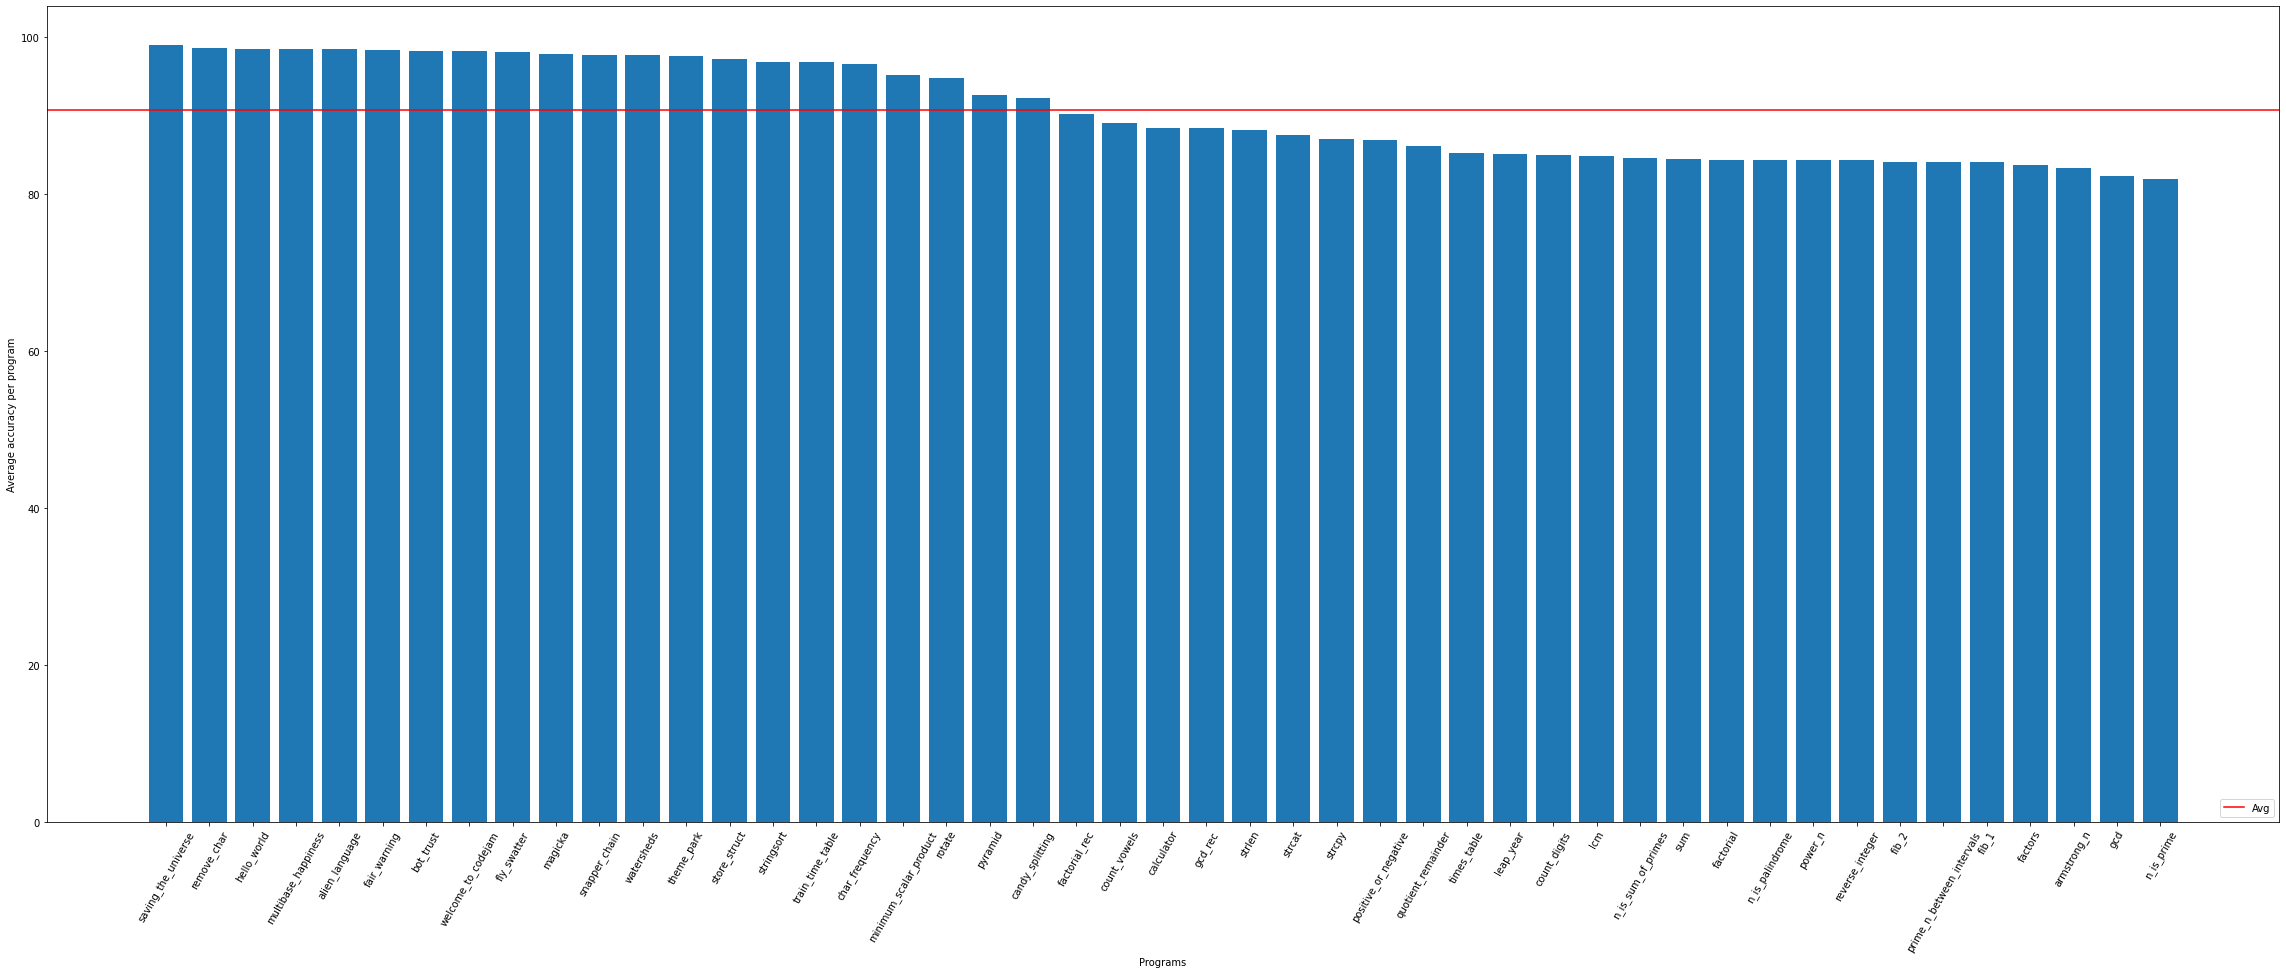

In [ ]:
fig = plt.figure(figsize=(40, 15))

plt.bar(list(sort_orders.keys()), sort_orders.values())
plt.axhline(np.asarray(list(sort_orders.values())).mean(), color="red", label="media")

plt.xticks(rotation=60)

plt.ylabel('Average accuracy per program')
plt.xlabel('Programs')
plt.legend(['Avg'], loc='lower right')

#Display the graph
plt.show(fig)

fig.savefig("AccuracyMedia_programma_tot.pdf", bbox_inches='tight')

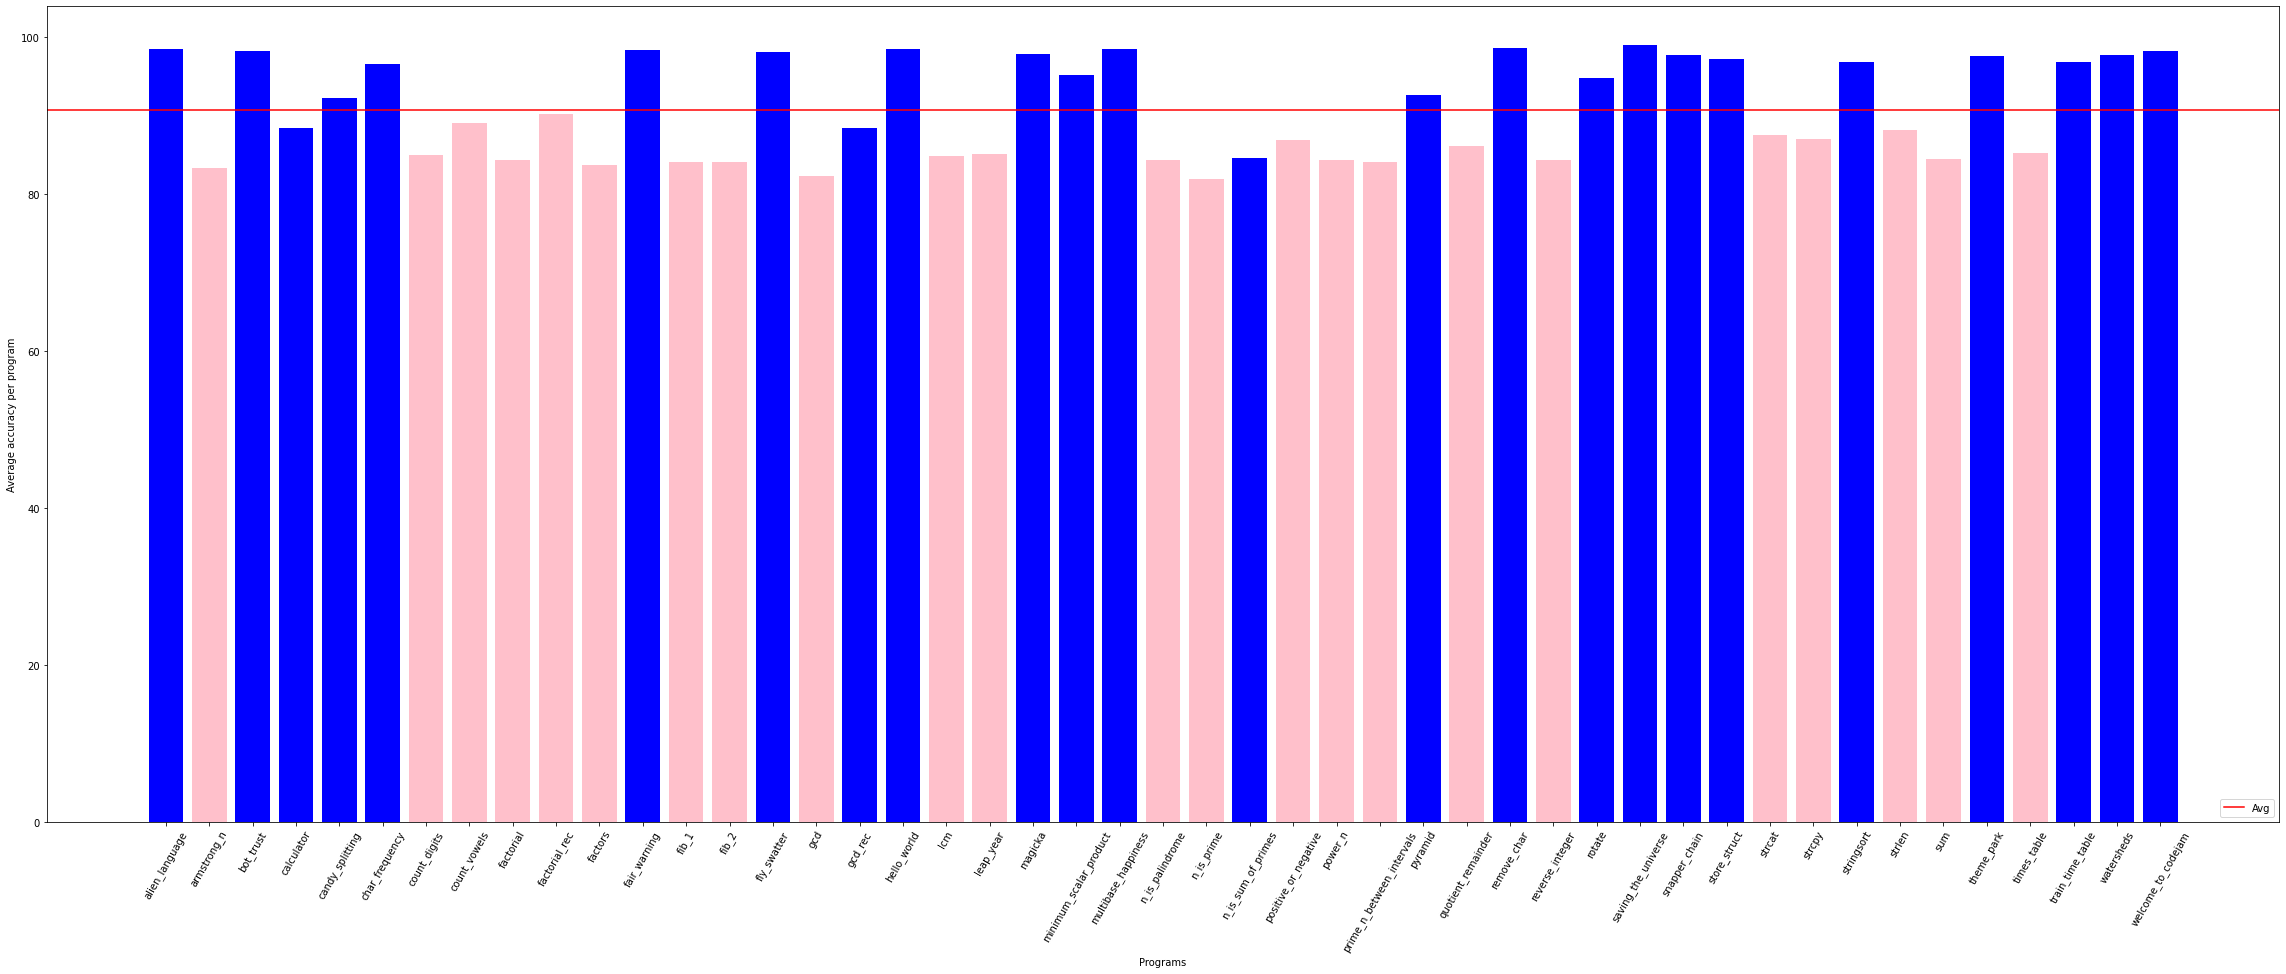

In [ ]:
_valori = np.asarray(list(diz_classe_acc.values()))

mean = np.asarray(list(diz_classe_dvstd.values())).mean()
col = []
for val in diz_classe_dvstd.values():
    if val > mean:
        col.append('pink')
    else:
        col.append('blue')

fig = plt.figure(figsize=(40, 15))

plt.bar(list(diz_classe_acc.keys()), diz_classe_acc.values(), color = col)
plt.axhline(_valori.mean(), color="red", label="media")
#plt.axhline(_valori.min(), color="purple", label="min")
#plt.axhline(_valori.max(), color="black", label="max")

plt.xticks(rotation=60)

plt.ylabel('Average accuracy per program')
plt.xlabel('Programs')
plt.legend(['Avg'], loc='lower right')

#Display the graph
plt.show(fig)

fig.savefig("AccuracyMedia_programma_tot.pdf", bbox_inches='tight')

In [ ]:
lista_to_plot_acc = list()
lista_to_plot_std = list()

for k, v in acc_diz.items():
  lista_to_plot_acc.append(v[0])
  lista_to_plot_std.append(v[1])

np_to_plot_acc = np.asarray(lista_to_plot_acc)
np_to_plot_std = np.asarray(lista_to_plot_std)

In [ ]:
diz_grafo_enc_lit = dict()
for k, d in agglom_singoli_media.items():
  val = d.get("EncodeLiterals")
  diz_grafo_enc_lit.update({k : val})

diz_grafo_enc_arith = dict()
for k, d in agglom_singoli_media.items():
  val = d.get("EncodeArithmetic")
  diz_grafo_enc_arith.update({k : val})

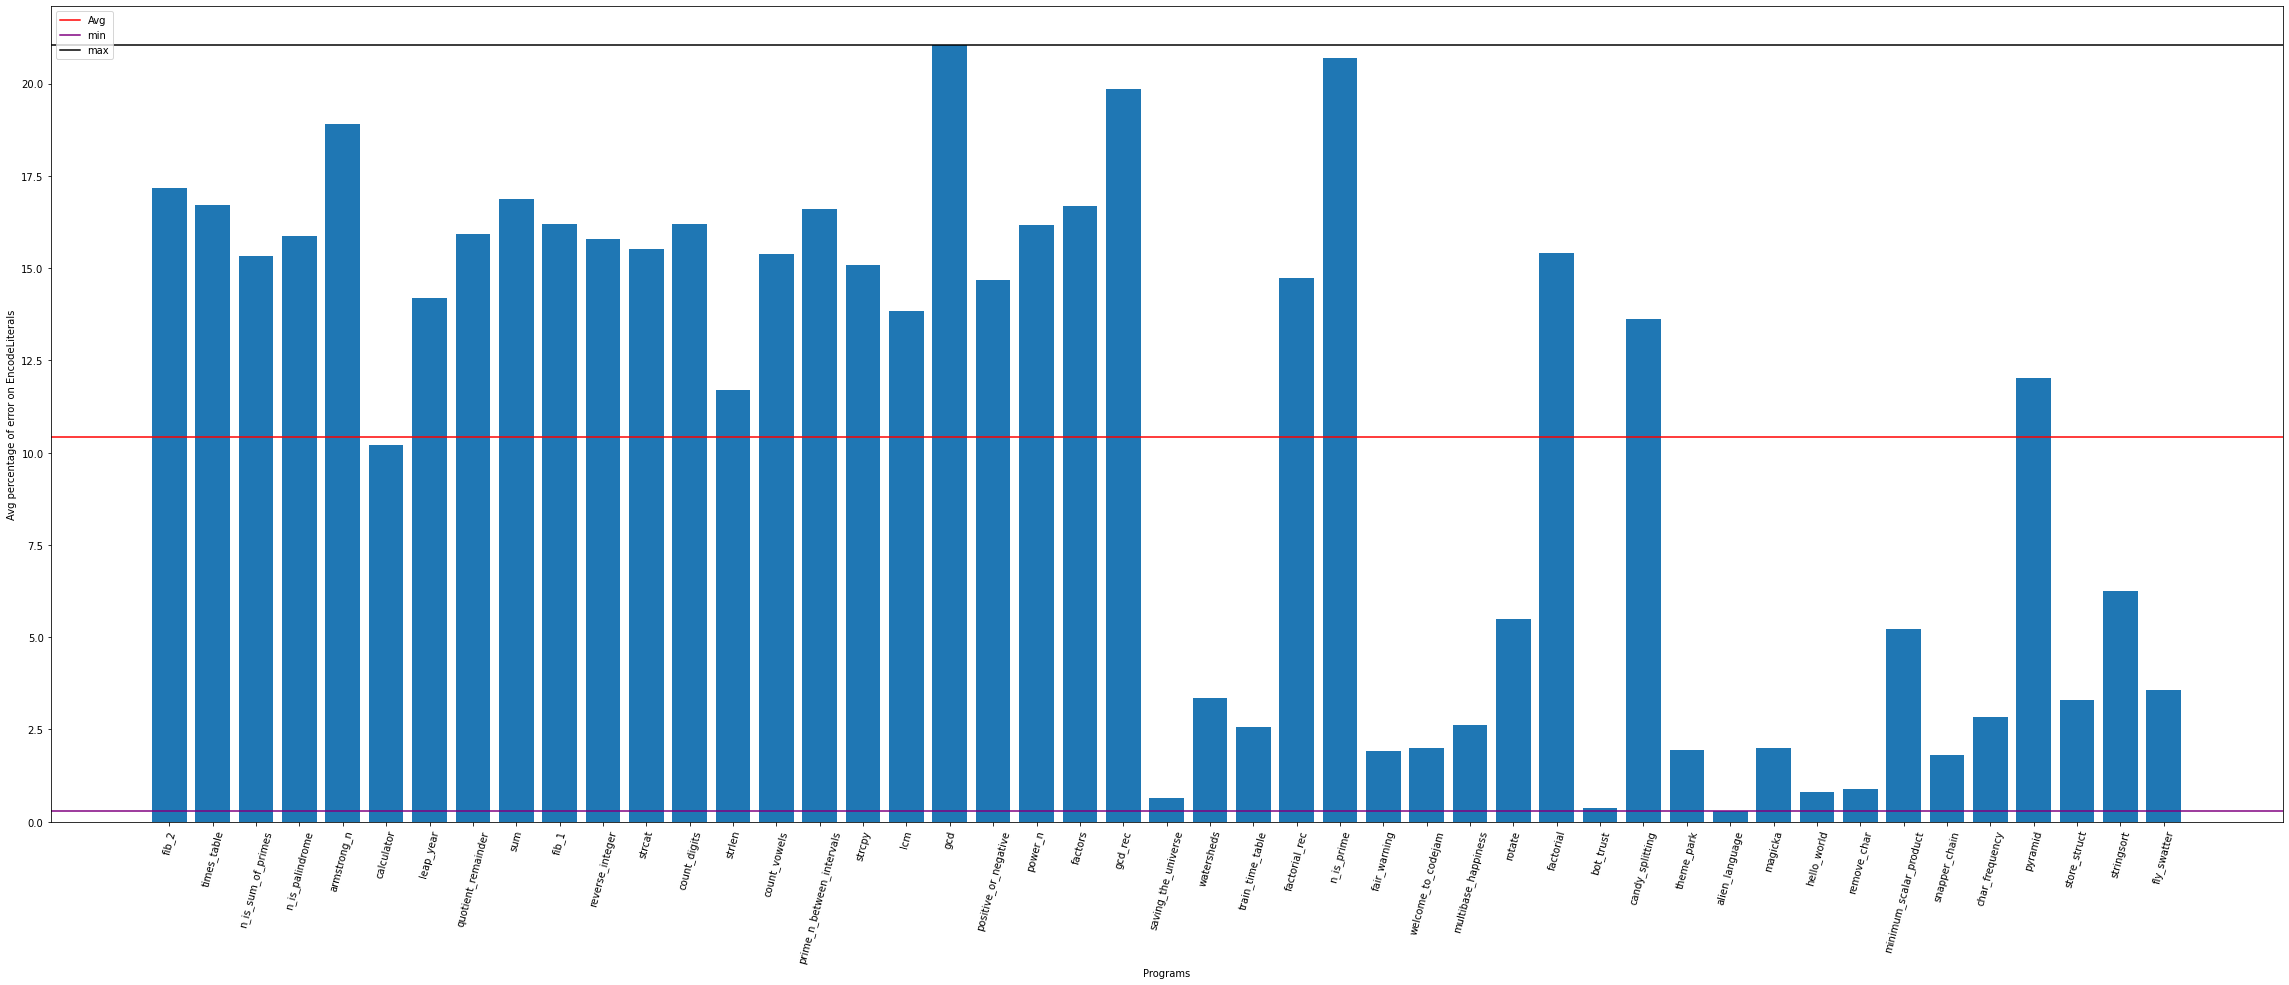

In [ ]:
#EncodeLiterals
diz_obf1 = dict()
for k, d in agglom_singoli_media.items():
  val = d.get("EncodeLiterals")
  diz_obf1.update({k : val})

#Figure
fig = plt.figure(figsize=(40, 15))

plt.bar(list(diz_obf1.keys()), diz_obf1.values())

plt.axhline(np.asarray(list(diz_obf1.values())).mean(), color="red")
plt.axhline(np.asarray(list(diz_obf1.values())).min(), color="purple")
plt.axhline(np.asarray(list(diz_obf1.values())).max(), color="black")

plt.xticks(rotation=75)

plt.ylabel('Avg percentage of error on EncodeLiterals')
plt.xlabel('Programs')

plt.legend(['Avg', 'min', 'max'], loc='upper left')

# Display the graph
plt.show(fig)

fig.savefig("avgErrEncodeLitHor.pdf", bbox_inches='tight')